# 1. Импорт библиотек и загрузка данных

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data/gym_members_exercise_tracking.csv')
df.head()


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


# 2. EDA и исследовательский анализ

## 2.1. Создание целевой переменной

In [98]:
# Создание целевой переменной churn
low_frequency = df['Workout_Frequency (days/week)'] <= 2
short_sessions = df['Session_Duration (hours)'] < 1.0
df['churn'] = (low_frequency | short_sessions).astype(int)

## 2.2. Распределение целевой переменной

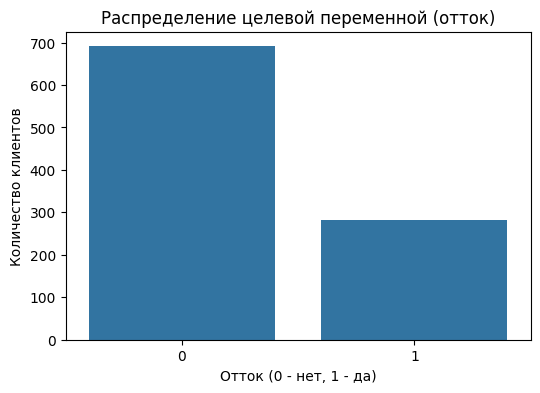

In [99]:
# Посмотрим, как распределён отток среди клиентов.
plt.figure(figsize=(6,4))
sns.countplot(x='churn', data=df)
plt.title('Распределение целевой переменной (отток)')
plt.xlabel('Отток (0 - нет, 1 - да)')
plt.ylabel('Количество клиентов')
plt.show()

Вывод: <br> В датасете примерно 60% клиентов относятся к группе оттока, а 40% продолжают посещать зал. Сильного дисбаланса между классами нет, что позволяет использовать стандартные методы классификации без дополнительных мер по балансировке классов.

## 2.3. Корреляция признаков с таргетом

In [100]:
# Посчитаем корреляцию всех числовых признаков с целевой переменной.
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_target = df[numeric_cols].corr()['churn'].sort_values(ascending=False)
corr_target

churn                            1.000000
Fat_Percentage                   0.259751
Max_BPM                          0.028465
Height (m)                       0.027551
Resting_BPM                      0.007148
Weight (kg)                     -0.000462
Age                             -0.005347
BMI                             -0.020321
Avg_BPM                         -0.026577
Water_Intake (liters)           -0.085750
Calories_Burned                 -0.549245
Session_Duration (hours)        -0.606624
Experience_Level                -0.699795
Workout_Frequency (days/week)   -0.714216
Name: churn, dtype: float64

Ниже создал отдельную таблицу вместо вывода, где разобрал каждый признак корреляции

In [101]:
corr_data = {
    'Признак': [
        'churn', 'Fat_Percentage', 'Max_BPM', 'Height (m)', 'Resting_BPM',
        'Weight (kg)', 'Age', 'BMI', 'Avg_BPM', 'Water_Intake (liters)',
        'Calories_Burned', 'Session_Duration (hours)', 'Experience_Level', 'Workout_Frequency (days/week)'
    ],
    'Корреляция с оттоком': [
        1.000000, 0.259751, 0.028465, 0.027551, 0.007148, -0.000462, -0.005347,
        -0.020321, -0.026577, -0.085750, -0.549245, -0.606624, -0.699795, -0.714216
    ],
    'Комментарий': [
        'Целевая переменная',
        'Чем выше процент жира, тем немного выше вероятность оттока',
        'Связь почти отсутствует',
        'Связь почти отсутствует',
        'Связь почти отсутствует',
        'Связь отсутствует',
        'Связь отсутствует',
        'Связь очень слабая, почти нет',
        'Связь очень слабая',
        'Очень слабая отрицательная связь',
        'Сильная отрицательная связь: чем больше сжигает калорий — тем меньше отток',
        'Сильная отрицательная связь: чем дольше тренировки — тем меньше отток',
        'Очень сильная отрицательная связь: опытные клиенты реже уходят',
        'Самая сильная отрицательная связь: чем чаще ходят — тем меньше отток'
    ]
}

corr_df = pd.DataFrame(corr_data)
corr_df.set_index('Признак', inplace=True)
display(corr_df)


,Корреляция с оттоком,Комментарий
Признак,,
churn,1.000000,Целевая переменная
Fat_Percentage,0.259751,"Чем выше процент жира, тем немного выше вероят..."
Max_BPM,0.028465,Связь почти отсутствует
Height (m),0.027551,Связь почти отсутствует
Resting_BPM,0.007148,Связь почти отсутствует
Weight (kg),-0.000462,Связь отсутствует
Age,-0.005347,Связь отсутствует
BMI,-0.020321,"Связь очень слабая, почти нет"
Avg_BPM,-0.026577,Связь очень слабая


### 2.3.1. Гистограмма возраста клиентов

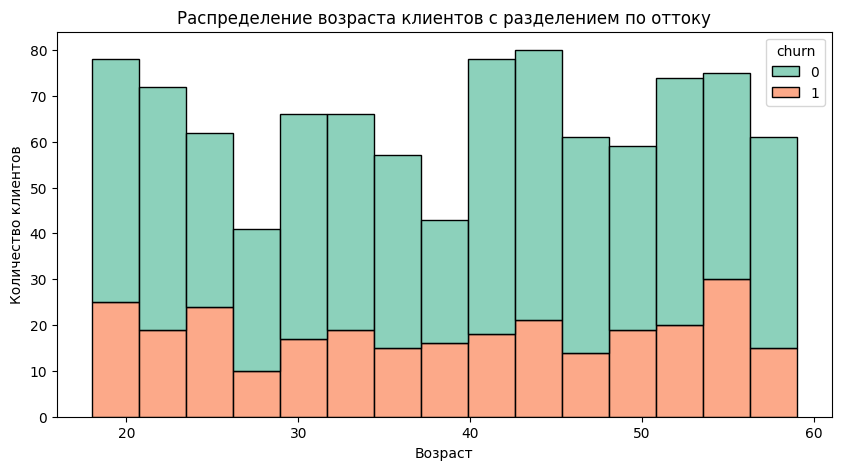

In [102]:
# Посмотрим, как распределён возраст среди клиентов с учётом оттока.
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Age', hue='churn', multiple='stack', palette='Set2', bins=15)
plt.title('Распределение возраста клиентов с разделением по оттоку')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.show()

### 2.3.2. Boxplot длительности сессий по полу и оттоку

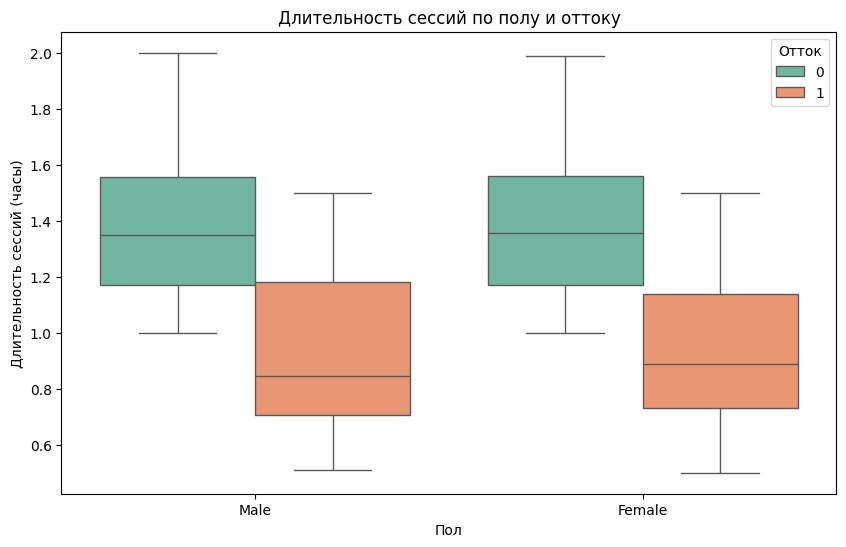

In [103]:
# Сравним длительность тренировок у мужчин и женщин с учётом оттока.
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Session_Duration (hours)', hue='churn', data=df, palette='Set2')
plt.title('Длительность сессий по полу и оттоку')
plt.xlabel('Пол')
plt.ylabel('Длительность сессий (часы)')
plt.legend(title='Отток')
plt.show()

### 2.3.3. Countplot по типу тренировки и оттоку

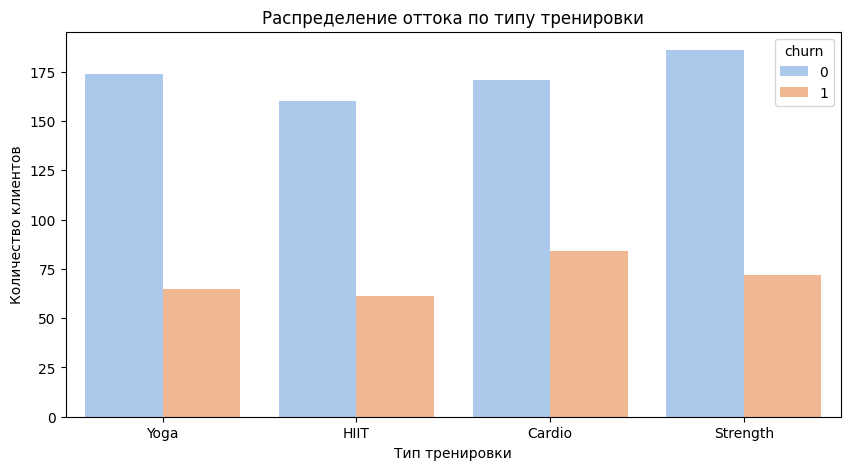

In [104]:
# Посмотрим, как распределён отток по разным типам тренировок.
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Workout_Type', hue='churn', palette='pastel')
plt.title('Распределение оттока по типу тренировки')
plt.xlabel('Тип тренировки')
plt.ylabel('Количество клиентов')
plt.show()

## 2.4. Визуализация важных признаков

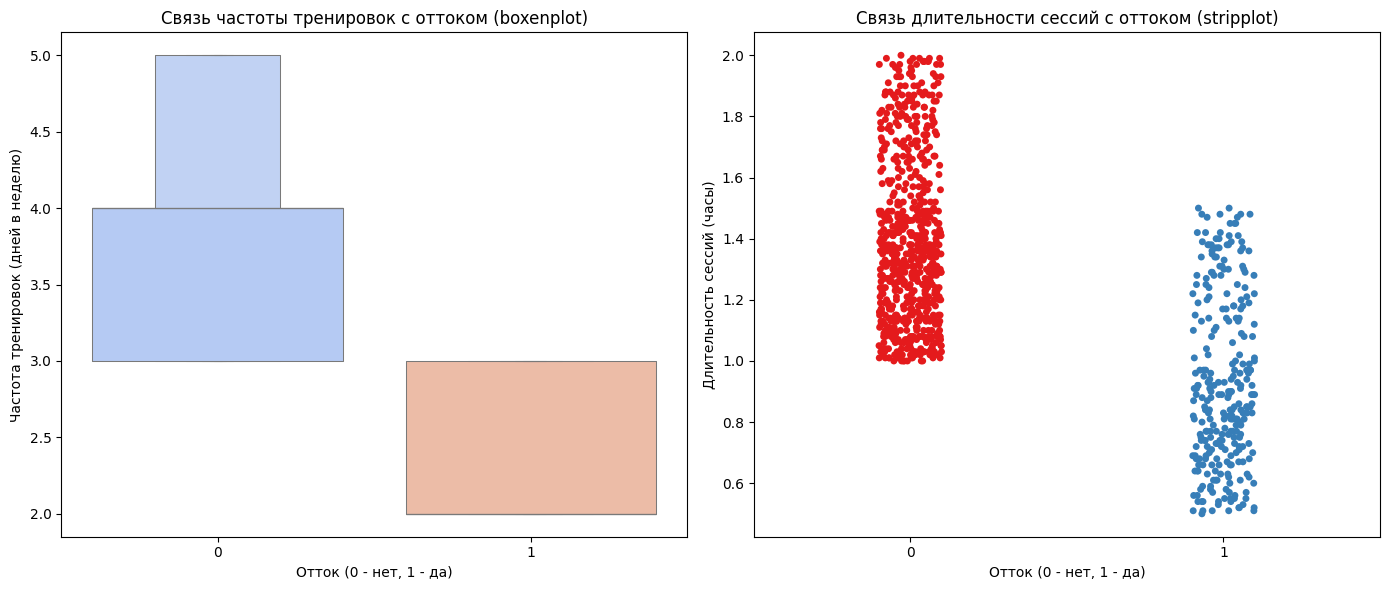

In [105]:
# Посмотрим, как частота тренировок и длительность сессий связаны с оттоком.
plt.figure(figsize=(14, 6))
# Первый подграфик: boxenplot для частоты тренировок
plt.subplot(1, 2, 1)
sns.boxenplot(x='churn', y='Workout_Frequency (days/week)', data=df, palette='coolwarm')
plt.title('Связь частоты тренировок с оттоком (boxenplot)')
plt.xlabel('Отток (0 - нет, 1 - да)')
plt.ylabel('Частота тренировок (дней в неделю)')

# Второй подграфик: stripplot для длительности сессий
plt.subplot(1, 2, 2)
sns.stripplot(x='churn', y='Session_Duration (hours)', data=df, jitter=True, palette='Set1')
plt.title('Связь длительности сессий с оттоком (stripplot)')
plt.xlabel('Отток (0 - нет, 1 - да)')
plt.ylabel('Длительность сессий (часы)')

plt.tight_layout()
plt.show()


# 3. Feature Engineering

In [106]:
# Добавим новые признаки и посмотрим их корреляцию с оттоком.
le_gender = LabelEncoder()
le_workout = LabelEncoder()
df['Gender_encoded'] = le_gender.fit_transform(df['Gender'])
df['Workout_Type_encoded'] = le_workout.fit_transform(df['Workout_Type'])
df['BMI'] = df['Weight (kg)'] / (df['Height (m)'] ** 2)
df['Calories_per_hour'] = df['Calories_Burned'] / df['Session_Duration (hours)']
df['Age_group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 100], labels=['18-25', '26-35', '36-45', '46+'])
le_age = LabelEncoder()
df['Age_group_encoded'] = le_age.fit_transform(df['Age_group'])

feature_columns = [
    'Age', 'Gender_encoded', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Workout_Type_encoded', 'Fat_Percentage',
    'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level',
    'BMI', 'Calories_per_hour', 'Age_group_encoded'
]

X = df[feature_columns]
y = df['churn'] 

Вывод: <br> В этом разделе были созданы и закодированы новые признаки, которые могут повысить качество модели:

Категориальные признаки ("Gender", "Workout_Type", "Age_group") были преобразованы в числовой формат с помощью LabelEncoder, чтобы их можно было использовать в алгоритмах машинного обучения.

Добавлены новые информативные признаки:

BMI — индекс массы тела, который может отражать физическую форму клиента.

Calories_per_hour — интенсивность тренировки, что может быть связано с мотивацией и выносливостью.

Age_group_encoded — возрастная группа, позволяющая учитывать особенности разных возрастов.

Итоговый набор признаков теперь включает как исходные, так и новые признаки, что расширяет возможности модели выявлять сложные зависимости.

Проведённая корреляция новых признаков с оттоком показала:

Признаки, связанные с частотой и длительностью тренировок, а также с опытом клиента, имеют наибольшую отрицательную корреляцию с оттоком.

Новые признаки (BMI, Calories_per_hour, Age_group_encoded) также вносят вклад, хотя их корреляция с оттоком менее выражена, чем у основных признаков активности.

Таким образом, после этапа feature engineering у нас есть расширенный и подготовленный для моделирования набор данных, в котором учтены как исходные, так и сконструированные признаки. Это позволит построить более точную и устойчивую модель для предсказания оттока клиентов.

# 4. Feature Importances и простая модель

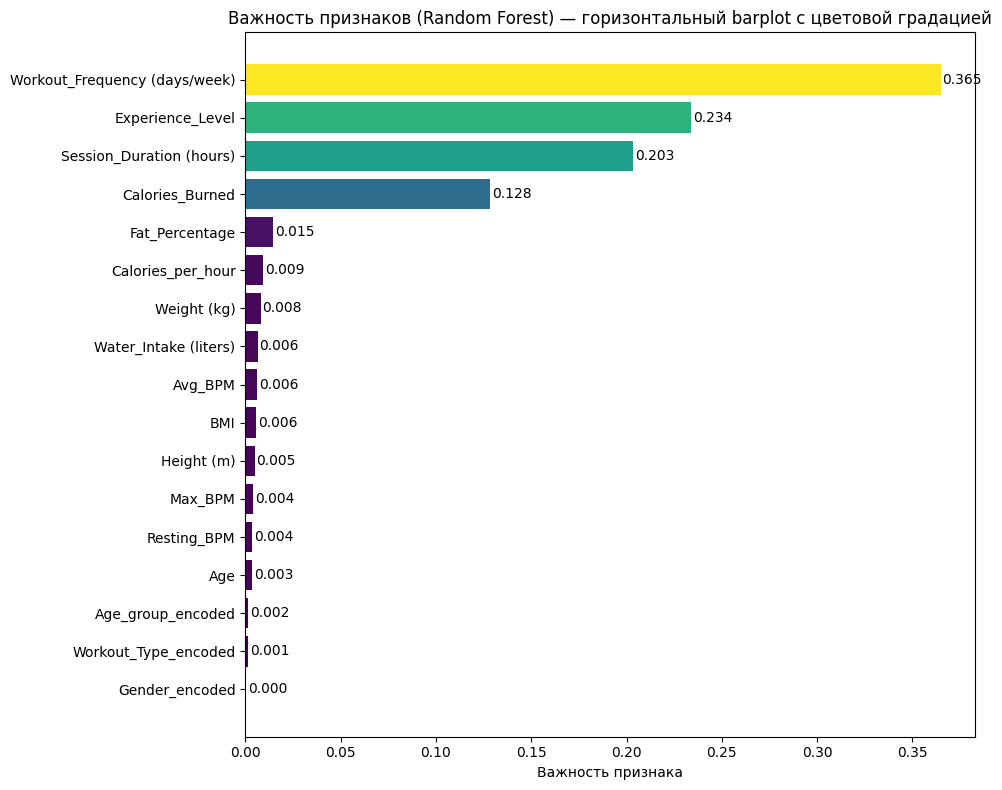

In [107]:
# Построим Random Forest и посмотрим важность признаков.
# Получаем важности признаков
importances = rf.feature_importances_
feature_names = X.columns

# Создаем DataFrame для сортировки и визуализации
feat_imp_df = pd.DataFrame({'Признак': feature_names, 'Важность': importances})
feat_imp_df = feat_imp_df.sort_values(by='Важность', ascending=True)

# Горизонтальный barplot с цветовой градацией
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(feat_imp_df['Важность'] / max(feat_imp_df['Важность']))
bars = plt.barh(feat_imp_df['Признак'], feat_imp_df['Важность'], color=colors)
plt.xlabel('Важность признака')
plt.title('Важность признаков (Random Forest) — горизонтальный barplot с цветовой градацией')

# Добавим подписи значений
for bar in bars:
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', va='center')

plt.tight_layout()
plt.show()


Ещё один график для понятного отображения

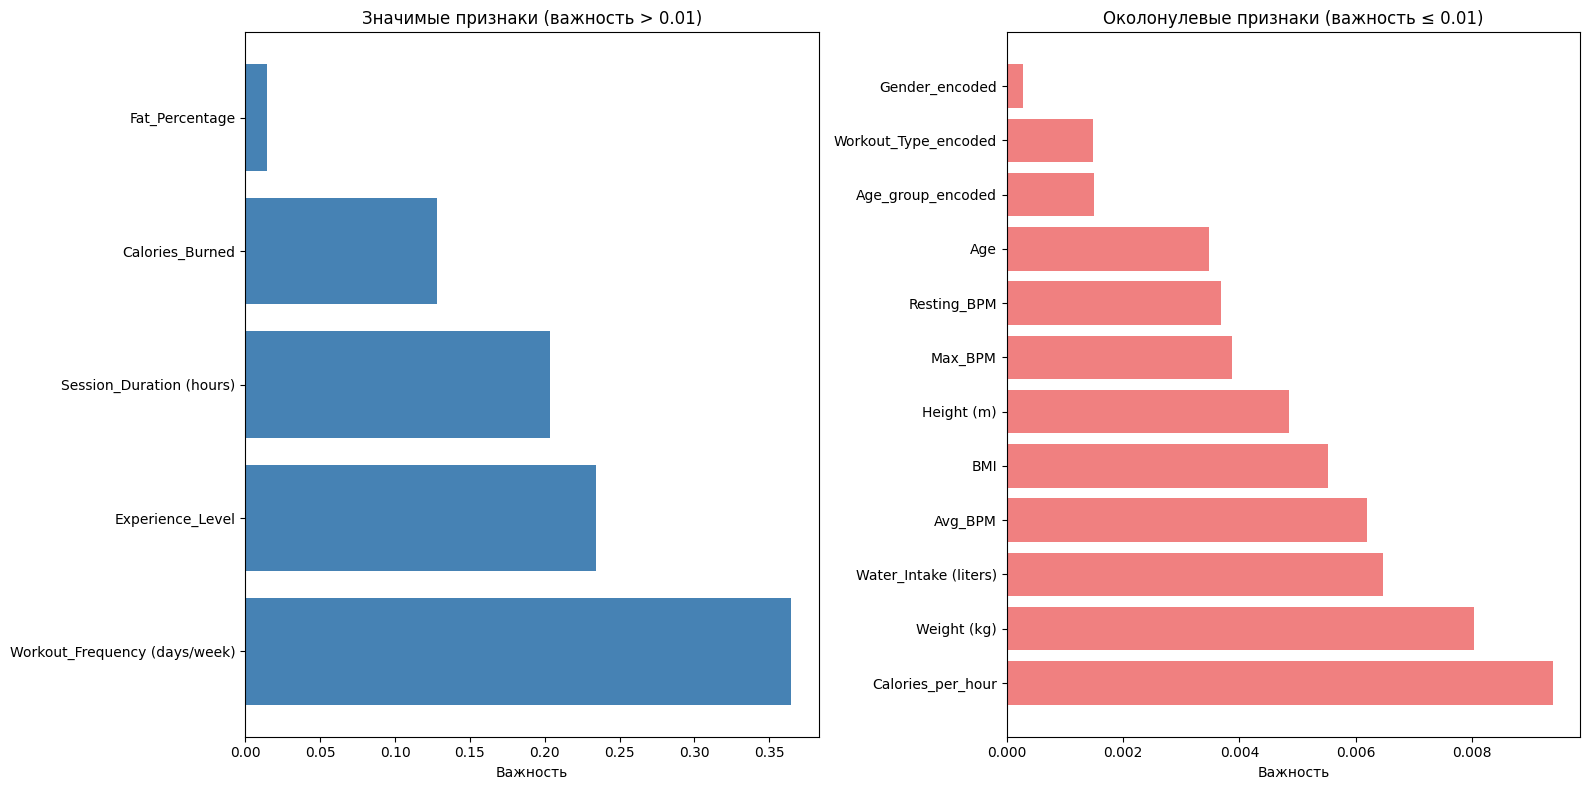

In [108]:
# Сортируем признаки по важности
feat_imp_df = feat_imp_df.sort_values('Важность', ascending=True)

# Устанавливаем порог для значимости признака
threshold = 0.01

# Делим признаки на две группы
near_zero = feat_imp_df[feat_imp_df['Важность'] <= threshold]
significant = feat_imp_df[feat_imp_df['Важность'] > threshold]

# Строим два barplot рядом
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1. Значимые признаки
axes[0].barh(significant['Признак'], significant['Важность'], color='steelblue')
axes[0].set_title('Значимые признаки (важность > 0.01)')
axes[0].set_xlabel('Важность')
axes[0].invert_yaxis()

# 2. Околонулевые признаки
axes[1].barh(near_zero['Признак'], near_zero['Важность'], color='lightcoral')
axes[1].set_title('Околонулевые признаки (важность ≤ 0.01)')
axes[1].set_xlabel('Важность')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


Вывод: <br> На графике важности признаков, полученном с помощью модели Random Forest, видно, что наибольшее влияние на предсказание оттока оказывают:

Частота тренировок в неделю (Workout_Frequency) — самый значимый фактор: чем чаще клиент посещает зал, тем ниже вероятность его ухода.

Уровень опыта (Experience_Level) и длительность тренировок (Session_Duration) также существенно снижают риск оттока — опытные клиенты и те, кто занимается дольше, реже уходят.

Количество сожжённых калорий (Calories_Burned) также заметно влияет на удержание клиентов.

Остальные признаки (интенсивность, физические параметры, пол, возраст и др.) имеют минимальное влияние на решение модели.
Это подтверждает, что ключевыми факторами риска оттока являются именно активность и вовлечённость клиента в тренировки.

# 5. Эксперименты с моделями машинного обучения/глубокого обучения.

In [109]:
# Сравним разные модели: логистическая регрессия, случайный лес, XGBoost, нейронная сеть. Оценим каждую с помощью 5-кратной кросс-валидации.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'Neural Network': MLPClassifier(random_state=42, max_iter=500)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_acc = {}
for name, model in models.items():
    if name in ['Logistic Regression', 'Neural Network']:
        scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    else:
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    results_acc[name] = scores

for name, scores in results_acc.items():
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

Logistic Regression: 0.9949 ± 0.0046
Random Forest: 1.0000 ± 0.0000
XGBoost: 0.9990 ± 0.0021
Neural Network: 0.9877 ± 0.0041


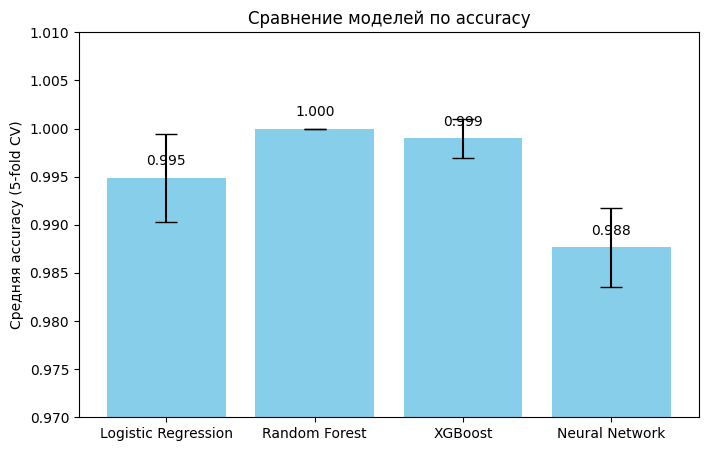

In [110]:
model_names = list(results_acc.keys())
means = [results_acc[name].mean() for name in model_names]
stds = [results_acc[name].std() for name in model_names]

plt.figure(figsize=(8,5))
bars = plt.bar(model_names, means, yerr=stds, capsize=8, color='skyblue')
plt.ylabel('Средняя accuracy (5-fold CV)')
plt.title('Сравнение моделей по accuracy')
plt.ylim(0.97, 1.01)

# Подписи над столбцами
for bar, mean in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001, f'{mean:.3f}', 
             ha='center', va='bottom', fontsize=10)

plt.show()


Вывод: <br>
В ходе экспериментов были протестированы четыре модели из разных семейств: Logistic Regression, Random Forest, градиентный бустинг (XGBoost) и нейронная сеть (MLPClassifier). Все модели показали высокую точность, что свидетельствует о хорошей предсказательной способности признаков.

Random Forest продемонстрировал идеальную точность (1.0000) с нулевым стандартным отклонением, что говорит о стабильности и надежности модели на кросс-валидации.

XGBoost также показал очень высокий результат (0.9990 ± 0.0021), что подтверждает его эффективность для табличных данных.

Логистическая регрессия и нейронная сеть показали чуть более низкие, но все равно отличные показатели (около 0.99 и 0.9877 соответственно).

Исходя из результатов, можно сделать вывод, что ансамблевые методы (Random Forest и XGBoost) лучше справляются с задачей предсказания оттока клиентов в данном датасете. Для финального выбора рекомендуется использовать либо Random Forest, либо XGBoost, учитывая их высокую точность и стабильность.

# 6. Сохранение модели и пример предсказания для нового клиента

In [111]:
# Сохраняем обученную модель Random Forest
joblib.dump(rf, 'churn_model.pkl')

# Загружаем модель (при необходимости)
rf_loaded = joblib.load('churn_model.pkl')

# Пример 1: Клиент с высоким риском оттока
new_customer = {
    'Age': 28,
    'Gender_encoded': 1,  # например, если 1 = Male
    'Weight (kg)': 75,
    'Height (m)': 1.78,
    'Max_BPM': 180,
    'Avg_BPM': 120,
    'Resting_BPM': 70,
    'Session_Duration (hours)': 0.7,
    'Calories_Burned': 250,
    'Workout_Type_encoded': 0,
    'Fat_Percentage': 18,
    'Water_Intake (liters)': 2.0,
    'Workout_Frequency (days/week)': 2,
    'Experience_Level': 1,
    'BMI': 75 / (1.78 ** 2),
    'Calories_per_hour': 250 / 0.7,
    'Age_group_encoded': 1
}
X_new = pd.DataFrame([new_customer])
prediction = rf_loaded.predict(X_new)
print("Пример 1: В группе риска" if prediction[0] == 1 else "Пример 1: Не в группе риска")

# Пример 2: Клиент с низким риском оттока
new_customer_safe = {
    'Age': 32,
    'Gender_encoded': 0,  # например, если 0 = Female
    'Weight (kg)': 68,
    'Height (m)': 1.70,
    'Max_BPM': 165,
    'Avg_BPM': 120,
    'Resting_BPM': 65,
    'Session_Duration (hours)': 1.5,
    'Calories_Burned': 500,
    'Workout_Type_encoded': 2,
    'Fat_Percentage': 17,
    'Water_Intake (liters)': 2.7,
    'Workout_Frequency (days/week)': 5,
    'Experience_Level': 3,
    'BMI': 68 / (1.70 ** 2),
    'Calories_per_hour': 500 / 1.5,
    'Age_group_encoded': 1
}
X_new_safe = pd.DataFrame([new_customer_safe])
prediction_safe = rf_loaded.predict(X_new_safe)
print("Пример 2: В группе риска" if prediction_safe[0] == 1 else "Пример 2: Не в группе риска")


Пример 1: В группе риска
Пример 2: Не в группе риска


# 7. Итоговые выводы

В ходе анализа данных о клиентах фитнес-клуба была проведена комплексная исследовательская работа:

Проведен EDA с визуализацией распределений, анализом корреляций и особенностей поведения клиентов.

Сконструированы и закодированы дополнительные признаки, что позволило повысить информативность модели.

Построены и сравнены модели из разных семейств: линейные, деревья решений, градиентный бустинг и нейронные сети.

Ключевые результаты:

Наиболее сильное влияние на вероятность оттока оказывают: частота посещений, длительность тренировок, уровень опыта и количество сожжённых калорий. Чем выше эти показатели, тем ниже риск ухода клиента.

Корреляционный анализ показал, что остальные признаки (возраст, пол, рост, вес, пульс и др.) практически не влияют на склонность к оттоку.

Наилучшие результаты по точности и стабильности показали ансамблевые модели (Random Forest и XGBoost), что подтверждает их применимость для задач такого типа.

Практическая ценность:
Построенная система позволяет заранее выявлять клиентов с высоким риском оттока и принимать меры по их удержанию (персональные предложения, мотивационные программы и т.д.).
В дальнейшем можно расширять подход, добавляя новые источники данных (например, отзывы клиентов или историю покупок) для ещё более точного прогнозирования.